# 擬似相関チュートリアル Part 2: SHAP による特徴量重要度分析

## チュートリアル全体の構成
1. [擬似相関とは & データの準備](01_spurious_correlation_intro.ipynb)
2. **SHAP による特徴量重要度分析** (このノートブック)
3. [因果探索（LiNGAM）による構造推定](03_causal_discovery_lingam.ipynb)
4. [非線形関係における擬似相関の判別](04_nonlinear_verification.ipynb)
5. [まとめと使い分けガイドライン](05_summary.ipynb)

---
## 共通セットアップ

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams['font.family'] = 'Meiryo'
matplotlib.rcParams['axes.unicode_minus'] = False

df = pd.read_csv('dataset.csv')

# 真の因果構造を定義
DIRECT_CAUSES = ['X', 'M', 'M2', 'Z1', 'Z2', 'Z3', 'D1']
SPURIOUS_CORR = ['N1', 'N4', 'N5', 'N7']
INDEPENDENT   = ['N2', 'N3', 'N6']
UPSTREAM      = ['W1', 'W2', 'IV', 'IV2', 'P1']
features = [c for c in df.columns if c != 'Y']

print(f'データサイズ: {df.shape}')

データサイズ: (2000, 20)


---
## 3. SHAP による特徴量重要度

SHAP (SHapley Additive exPlanations) は、ゲーム理論のシャプレイ値に基づいて
各特徴量の予測への貢献度を算出する XAI 手法です。

**重要な注意**: SHAP は「予測への貢献」を測るものであり、「因果効果」を測るものではありません。

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import shap

# 全特徴量で Random Forest を訓練
X_all = df[features]
y = df['Y']

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.3, random_state=42
)

rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

print(f'R² (train): {rf.score(X_train, y_train):.4f}')
print(f'R² (test):  {rf.score(X_test, y_test):.4f}')

R² (train): 0.9881
R² (test):  0.9122


In [3]:
# SHAP 値を計算
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# SHAP 重要度 (mean |SHAP value|)
shap_importance = pd.Series(
    np.abs(shap_values).mean(axis=0),
    index=features
).sort_values(ascending=False)

print('=== SHAP 特徴量重要度 (上位) ===')
for i, (feat, imp) in enumerate(shap_importance.items()):
    tag = ''
    if feat in SPURIOUS_CORR:
        tag = ' ⚠️ 擬似相関!'
    elif feat in DIRECT_CAUSES:
        tag = ' ✓ 直接原因'
    elif feat in INDEPENDENT:
        tag = ' (独立ノイズ)'
    elif feat in UPSTREAM:
        tag = ' (上流変数)'
    print(f'  {i+1:2d}. {feat:4s}: {imp:.4f}{tag}')

=== SHAP 特徴量重要度 (上位) ===
   1. M   : 1.3902 ✓ 直接原因
   2. D1  : 0.4567 ✓ 直接原因
   3. X   : 0.3417 ✓ 直接原因
   4. M2  : 0.2077 ✓ 直接原因
   5. Z3  : 0.1037 ✓ 直接原因
   6. Z1  : 0.0873 ✓ 直接原因
   7. N7  : 0.0639 ⚠️ 擬似相関!
   8. Z2  : 0.0405 ✓ 直接原因
   9. N1  : 0.0335 ⚠️ 擬似相関!
  10. N4  : 0.0328 ⚠️ 擬似相関!
  11. W1  : 0.0302 (上流変数)
  12. P1  : 0.0254 (上流変数)
  13. N5  : 0.0089 ⚠️ 擬似相関!
  14. N6  : 0.0065 (独立ノイズ)
  15. N3  : 0.0063 (独立ノイズ)
  16. N2  : 0.0061 (独立ノイズ)
  17. W2  : 0.0035 (上流変数)
  18. IV  : 0.0013 (上流変数)
  19. IV2 : 0.0013 (上流変数)


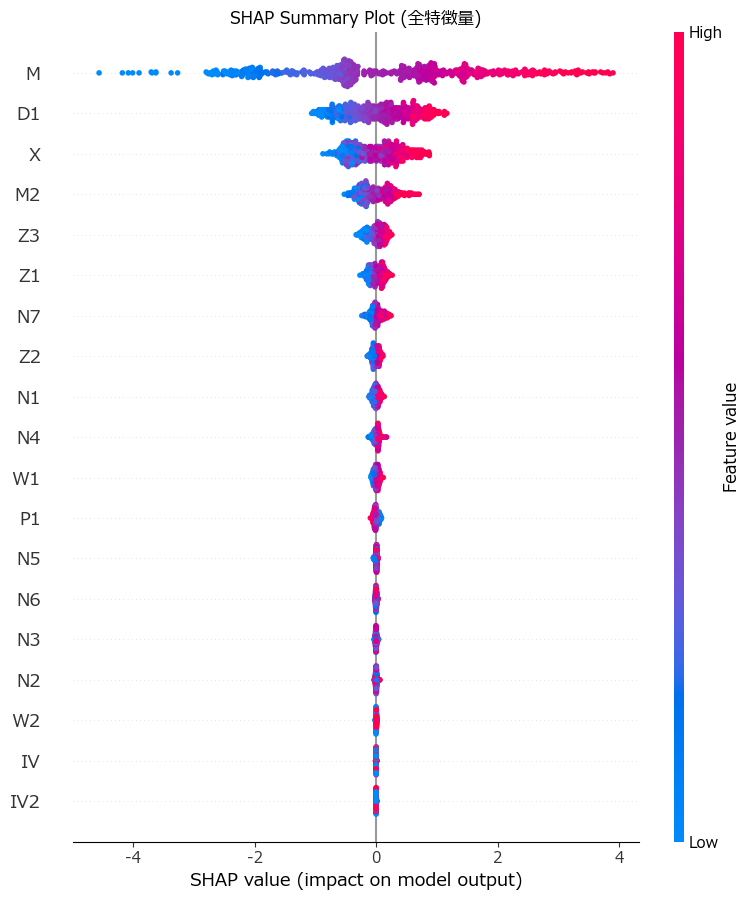

In [4]:
# SHAP summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, show=False, max_display=19)
plt.title('SHAP Summary Plot (全特徴量)')
plt.tight_layout()
plt.show()

---
## 4. SHAPが擬似相関に騙されるメカニズム

### なぜ SHAP は擬似相関変数に高い重要度を与えるのか？

SHAP は以下の問いに答えます:
> 「この特徴量がモデルの予測をどれだけ変化させたか？」

しかし、この問いは因果的な問い（介入の効果）とは異なります:
> 「この特徴量を操作したら、結果はどう変わるか？」

```
例: N4 = 0.7 * X + noise

N4 が大きい → X が大きい可能性が高い → Y も大きい可能性が高い

SHAP の視点: N4 は Y の予測に有用 → 高い重要度
因果の視点: N4 を操作しても Y は変化しない → 因果効果ゼロ
```

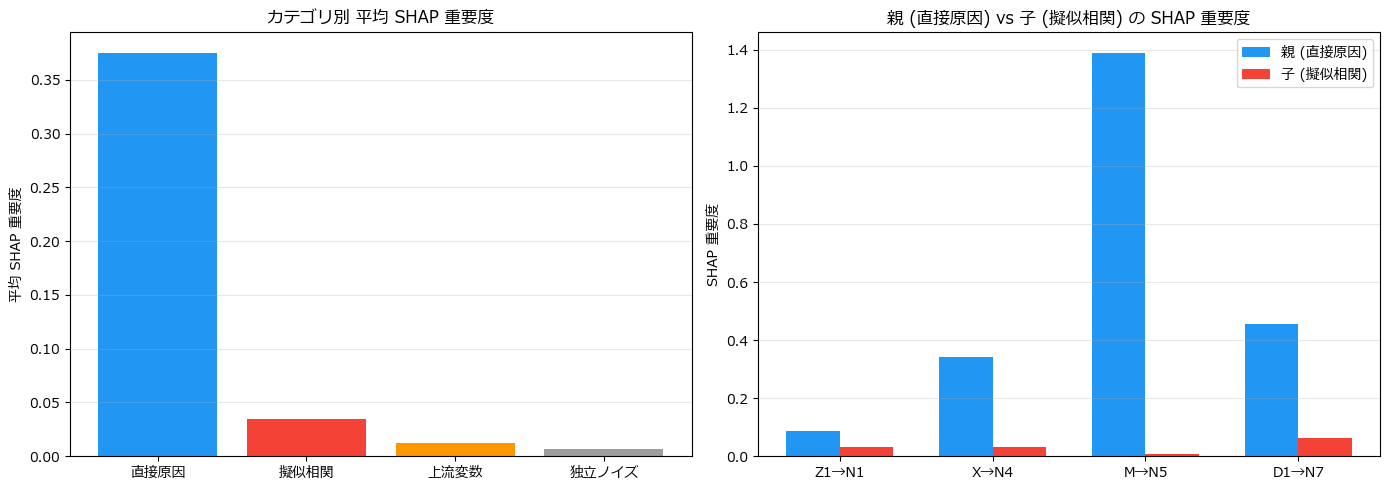


--- 要点 ---
擬似相関変数（赤）は Y に因果効果がないにもかかわらず、
SHAP では無視できない重要度を持っています。
これは SHAP が "予測への貢献" を測定するためです。


In [5]:
# 実験: 擬似相関変数 vs 直接原因の SHAP 重要度を比較
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- 左: カテゴリ別の平均 SHAP 重要度 ---
categories = {
    '直接原因': [shap_importance[f] for f in DIRECT_CAUSES],
    '擬似相関': [shap_importance[f] for f in SPURIOUS_CORR],
    '上流変数': [shap_importance[f] for f in UPSTREAM],
    '独立ノイズ': [shap_importance[f] for f in INDEPENDENT],
}
cat_names = list(categories.keys())
cat_means = [np.mean(v) for v in categories.values()]
cat_colors = ['#2196F3', '#F44336', '#FF9800', '#9E9E9E']

axes[0].bar(cat_names, cat_means, color=cat_colors)
axes[0].set_ylabel('平均 SHAP 重要度')
axes[0].set_title('カテゴリ別 平均 SHAP 重要度')
axes[0].grid(axis='y', alpha=0.3)

# --- 右: 擬似相関変数の詳細 ---
spurious_data = []
for feat in SPURIOUS_CORR:
    parent = {'N1': 'Z1', 'N4': 'X', 'N5': 'M', 'N7': 'D1'}[feat]
    spurious_data.append({
        'feature': feat,
        'shap': shap_importance[feat],
        'parent': parent,
        'parent_shap': shap_importance[parent],
    })
spurious_df = pd.DataFrame(spurious_data)

x_pos = np.arange(len(spurious_df))
width = 0.35
axes[1].bar(x_pos - width/2, spurious_df['parent_shap'], width,
            label='親 (直接原因)', color='#2196F3')
axes[1].bar(x_pos + width/2, spurious_df['shap'], width,
            label='子 (擬似相関)', color='#F44336')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([f"{r['parent']}→{r['feature']}" for _, r in spurious_df.iterrows()])
axes[1].set_ylabel('SHAP 重要度')
axes[1].set_title('親 (直接原因) vs 子 (擬似相関) の SHAP 重要度')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print('\n--- 要点 ---')
print('擬似相関変数（赤）は Y に因果効果がないにもかかわらず、')
print('SHAP では無視できない重要度を持っています。')
print('これは SHAP が "予測への貢献" を測定するためです。')

### SHAP の限界をさらに深掘り: 介入実験

擬似相関変数 N4 の値を操作しても、実際の Y は変わらないことを確認します。

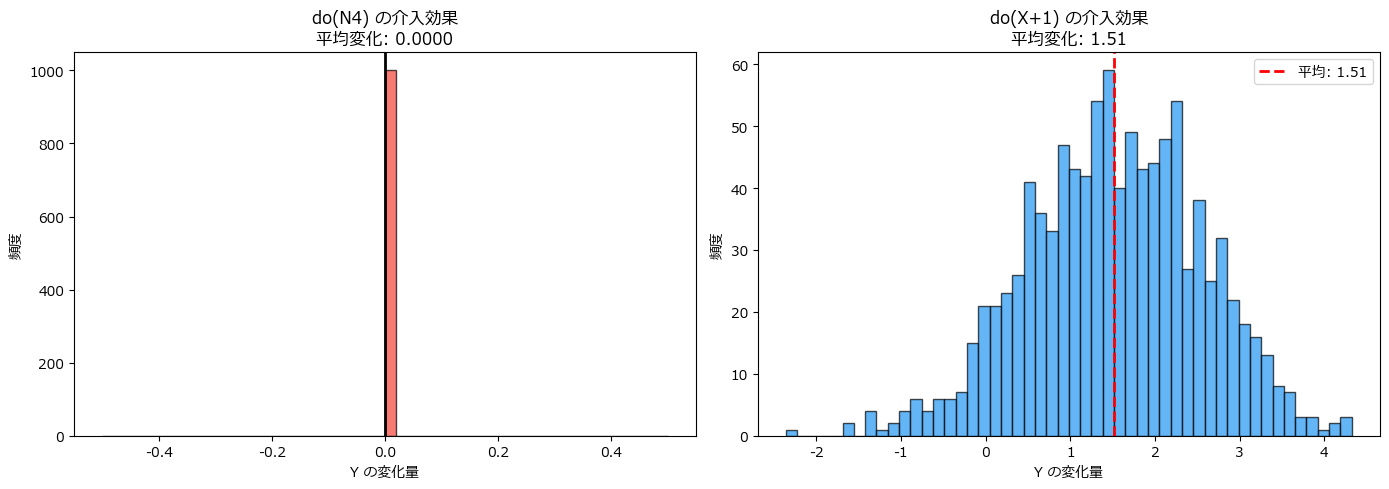

--- 介入実験の結果 ---
N4 を操作: Y の平均変化 = 0.0000  (因果効果なし ✓)
X を +1:   Y の平均変化 = 1.51  (因果効果あり ✓)

→ SHAP は N4 に重要度を与えるが、実際に操作しても Y は変化しない


In [6]:
# 介入実験: N4 を操作しても Y は変化しないことを示す
from generate_dataset import generate_data

# 元のデータ生成過程を利用した介入シミュレーション
rng = np.random.default_rng(99)
n_sim = 1000

# 固定された因果メカニズムでデータ生成
W1 = rng.normal(0, 1, n_sim)
W2 = rng.binomial(1, 0.5, n_sim).astype(float)
IV = rng.binomial(1, 0.5, n_sim).astype(float)
IV2 = rng.binomial(1, 0.5, n_sim).astype(float)
Z3 = rng.normal(0, 1, n_sim)
P1 = rng.normal(0, 1, n_sim)
D1 = rng.normal(0, 1, n_sim)

Z1 = 0.7 * W1 + rng.normal(0, 0.5, n_sim)
Z2 = 0.9 * W2 + rng.normal(0, 0.3, n_sim)
X = 0.6 * Z1 + 0.8 * Z2 + 1.2 * IV + 0.9 * IV2 + rng.normal(0, 0.5, n_sim)
M = 0.7 * X + 0.5 * Z3 + 0.4 * P1 + rng.normal(0, 0.5, n_sim)
M2 = 0.6 * X + rng.normal(0, 0.5, n_sim)
Y_original = 0.5*X + 0.9*M + 0.6*M2 + 0.4*Z1 + 0.3*Z2 + 0.5*Z3 + 0.7*D1 + rng.normal(0, 0.5, n_sim)

# 介入1: N4 を 0 に固定 (do(N4=0))
# N4 は Y の生成式に含まれないため、Y は変化しない
Y_after_do_N4 = Y_original.copy()  # Y は N4 に依存しないため同じ

# 介入2: X を +1 シフト (do(X=X+1))
# X は Y に直接影響し、M, M2 経由でも影響
X_shifted = X + 1
M_shifted = 0.7 * X_shifted + 0.5 * Z3 + 0.4 * P1 + rng.normal(0, 0.5, n_sim)
M2_shifted = 0.6 * X_shifted + rng.normal(0, 0.5, n_sim)
Y_after_do_X = 0.5*X_shifted + 0.9*M_shifted + 0.6*M2_shifted + 0.4*Z1 + 0.3*Z2 + 0.5*Z3 + 0.7*D1 + rng.normal(0, 0.5, n_sim)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左: do(N4) の効果
diff_n4 = Y_after_do_N4 - Y_original
axes[0].hist(diff_n4, bins=50, color='#F44336', alpha=0.7, edgecolor='black')
axes[0].axvline(x=0, color='black', linewidth=2)
axes[0].set_title(f'do(N4) の介入効果\n平均変化: {diff_n4.mean():.4f}')
axes[0].set_xlabel('Y の変化量')
axes[0].set_ylabel('頻度')

# 右: do(X+1) の効果
diff_x = Y_after_do_X - Y_original
axes[1].hist(diff_x, bins=50, color='#2196F3', alpha=0.7, edgecolor='black')
axes[1].axvline(x=diff_x.mean(), color='red', linewidth=2, linestyle='--',
                label=f'平均: {diff_x.mean():.2f}')
axes[1].set_title(f'do(X+1) の介入効果\n平均変化: {diff_x.mean():.2f}')
axes[1].set_xlabel('Y の変化量')
axes[1].set_ylabel('頻度')
axes[1].legend()

plt.tight_layout()
plt.show()

print('--- 介入実験の結果 ---')
print(f'N4 を操作: Y の平均変化 = {diff_n4.mean():.4f}  (因果効果なし ✓)')
print(f'X を +1:   Y の平均変化 = {diff_x.mean():.2f}  (因果効果あり ✓)')
print(f'\n→ SHAP は N4 に重要度を与えるが、実際に操作しても Y は変化しない')

---
次のノートブック: [03_causal_discovery_lingam.ipynb](03_causal_discovery_lingam.ipynb) で因果探索による構造推定を行います。